# Kalman Filtering

## Prediction Step

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [2]:
# parameters
T = 1.0 # sample time

In [3]:
def predict(x, P, F, Q):
    x = F @ x
    P = F @ P @ F.T + Q
    return x, P

In [4]:
def create_covariance_ellipse(pos, cov):
    # https://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix
    eig_values, eig_vectors = np.linalg.eig(cov)
    
    scale_95 = np.sqrt(5.991)
    radius_1 = scale_95 * eig_values[0]
    radius_2 = scale_95 * eig_values[1]
    angle = np.arctan2(eig_vectors[1, 1], eig_vectors[0, 1])
    
    #print("E-Values: ", eig_values)
    #print("E-Vectors: ", eig_vectors)
    #print("radius_1: ", radius_1)
    #print("radius_2: ", radius_2)
    #print("angle: ", angle)
    
    return radius_1, radius_2, angle

In [5]:
def draw_ellipse(ax, mu, radius_1, radius_2, angle, color):
    # https://matplotlib.org/stable/gallery/shapes_and_collections/ellipse_demo.html
    ellipse = Ellipse(
        mu,
        width=radius_1 * 2,
        height=radius_2 * 2,
        angle=np.rad2deg(angle) + 90,
        facecolor=color,
        alpha=0.4)

    ax.add_artist(ellipse)
    
    return ax

In [6]:
def plot_ellipse(ax, x, P, color):
    x = x[0:2].reshape(2,)
    P = P[0:2, 0:2]
    r1, r2, angle = create_covariance_ellipse(x, P)
    draw_ellipse(ax, x, r1, r2, angle, color)

In [7]:
def get_correlated_dataset(n, cov, mu, scale):
    # https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html
    latent = np.random.randn(n, 2)
    cov = latent.dot(cov)
    scaled = cov * scale
    scaled_with_offset = scaled + mu
    # return x and y of the new, correlated dataset
    return scaled_with_offset[:, 0], scaled_with_offset[:, 1]

In [8]:
def plot_samples(ax, samples_num, x, P, color, markersize, label):
    scale = 1, 1
    x, y = get_correlated_dataset(samples_num, P, x, scale)
    ax.scatter(x, y, s=markersize, marker='x', c=color, label=label)

In [9]:
def plot_mean(ax, x, size, color, label):
    ax.scatter(x[0], x[1], s=size, marker='o', c=color, label=label)

In [10]:
def plot_state(ax, x, P, samples_num, markersize, color, label):
    x = x[0:2].reshape(2,)
    P = P[0:2, 0:2]
    
    plot_ellipse(ax, x, P, color)
    plot_samples(ax, samples_num, x, P, color, markersize, label+'_possibility')
    plot_mean(ax, x, 100, color, label+'_mean')

In [11]:
def create_viewer(title, xlabel, ylabel, xlim=None, ylim=None):
    fig, viewer = plt.subplots(figsize=(20, 10), subplot_kw={'aspect': 'equal'})

    viewer.set_title(title, fontsize=20, color='green', fontweight='bold')
    
    viewer.axvline(c='grey', lw=2)
    viewer.axhline(c='grey', lw=2)

    viewer.set_xlabel(xlabel, fontweight ='bold')
    viewer.set_ylabel(ylabel, fontweight ='bold')
    
    if (xlim != None):
        viewer.set_xlim(xlim[0], xlim[1])
    
    if (ylim != None):
        viewer.set_ylim(ylim[0], ylim[1])
    
    return viewer

In [12]:
def visualize_estimate(viewer, label, color, x, P):
    print(label+' x', x, '\n')
    print(label+' P', P, '\n') 
    
    plot_state(viewer, x=x, P=P, samples_num=500, markersize=1, color=color, label=label+' x')

In [13]:
def update_plotter():
    plt.grid(visible=True)
    plt.legend(loc='upper right')
    plt.show()

### Example 1.A

We will assume that we know the initial position of the robot and also the velocity at that time.

$$
x_0 = \begin{bmatrix} p_X \\ p_y \\ v_x \\ v_y \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\ 2 \\ 0\end{bmatrix}
$$

Since the velocity along x-axis isn't zero, so one can expect that the robot will move by 2 units along x-axis at the next cycle, given that the sample time is 1 second $T = 1 sec$.

We can start guessing a value for the initial state covariance to be a very small value since we are confident about the initial position. And we will assume that the initial uncertainty of the velocities are much smaller compared to the position.

$$
P_0 = \begin{bmatrix} 0.1 & 0 & 0 & 0 \\ 0 & 0.1 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \end{bmatrix}
$$

Additional, we will try the first exercise without adding any process noise $Q=0_{4 \times 4}$

We notice that the prdicted position is moved by 2 units in the x-direction because of the $v_x$ and the state covariance is not changed at all since we assumed that the prediction model is accurate (no process noise is added, $Q=0_{4 \times 4}$).

In [14]:
def prepare_prediction_example_1A():
    # build initial state vector and covariance
    x = np.array([[0.], [0.], [2.], [0.]]) # px, py, vx, vy

    P = np.zeros((4, 4))
    P[0:2,0:2] = np.array([[0.1, 0.0], [0.0, 0.1]])
    P[2:4,2:4] = np.array([[0.0, 0.0], [0.0, 0.0]])

    F = np.array([[1., 0., T, 0.],
                  [0., 1., 0., T],
                  [0., 0., 1., 0.],
                  [0., 0., 0., 1.]])

    Q = np.zeros((4, 4))
    
    return x, P, F, Q

initial x [[0.]
 [0.]
 [2.]
 [0.]] 

initial P [[0.1 0.  0.  0. ]
 [0.  0.1 0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]] 

predict x [[2.]
 [0.]
 [2.]
 [0.]] 

predict P [[0.1 0.  0.  0. ]
 [0.  0.1 0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]] 



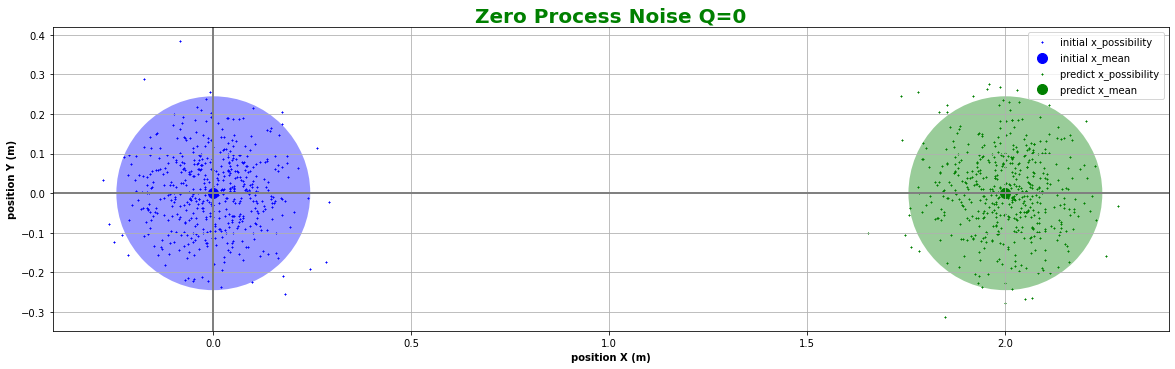

In [15]:
# Example (1)

# propagating the previous state through the state transition matrix F_k
x0, P0, F, Q = prepare_prediction_example_1A()

x1, P1 = predict(x0, P0, F, Q)

viewer = create_viewer('Zero Process Noise Q=0', 'position X (m)', 'position Y (m)')

visualize_estimate(viewer, 'initial', 'b', x0, P0)
visualize_estimate(viewer, 'predict', 'g', x1, P1)

update_plotter()

### Example 1.B
Next, we try to give some uncertainty in our model by setting the process noise as explained before.

$$
Q_k' =
\begin{bmatrix}
    q_{11}T+q_{33}\frac{T^3}{3} & 0 & q_{33} \frac{T^2}{2} & 0 \\
    0 & q_{22}T+q_{44}\frac{T^3}{3} & 0 & q_{44} \frac{T^2}{2} \\
    q_{33} \frac{T^2}{2} & 0 & q_{33} T & 0 \\
    0 & q_{44} \frac{T^2}{2} & 0 & q_{44} T \\
\end{bmatrix}
$$

Then we set the values of $q_{11}$, $q_{22}$, $q_{33}$, and $q_{44}$ to $0.1$.

We notice that now the predicted state has wider uncertainty because we reduced the model accuracy by setting the process noise covariance $Q$.


In [16]:
def prepare_prediction_example_1B():
    # build initial state vector and covariance
    x = np.array([[0.], [0.], [2.], [0.]]) # px, py, vx, vy

    P = np.zeros((4, 4))
    P[0:2,0:2] = np.array([[0.1, 0.0], [0.0, 0.1]])
    P[2:4,2:4] = np.array([[0.0, 0.0], [0.0, 0.0]])

    F = np.array([[1., 0., T, 0.],
                  [0., 1., 0., T],
                  [0., 0., 1., 0.],
                  [0., 0., 0., 1.]])

    q_11 = 0.1
    q_22 = 0.1
    q_33 = 0.1
    q_44 = 0.1

    Q = np.array([[q_11 * T + q_33 * (T**3/3), 0., q_33 * (T**2/2), 0.],
                  [0., q_22 * T + q_44 * (T**3/3), 0., q_44 * (T**2/2)],
                  [q_33 * (T**2/2), 0., q_33 * T, 0.],
                  [0., q_44 * (T**2/2), 0., q_44 * T]])
    
    return x, P, F, Q

initial x [[0.]
 [0.]
 [2.]
 [0.]] 

initial P [[0.1 0.  0.  0. ]
 [0.  0.1 0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]] 

predict x [[2.]
 [0.]
 [2.]
 [0.]] 

predict P [[0.23333333 0.         0.05       0.        ]
 [0.         0.23333333 0.         0.05      ]
 [0.05       0.         0.1        0.        ]
 [0.         0.05       0.         0.1       ]] 



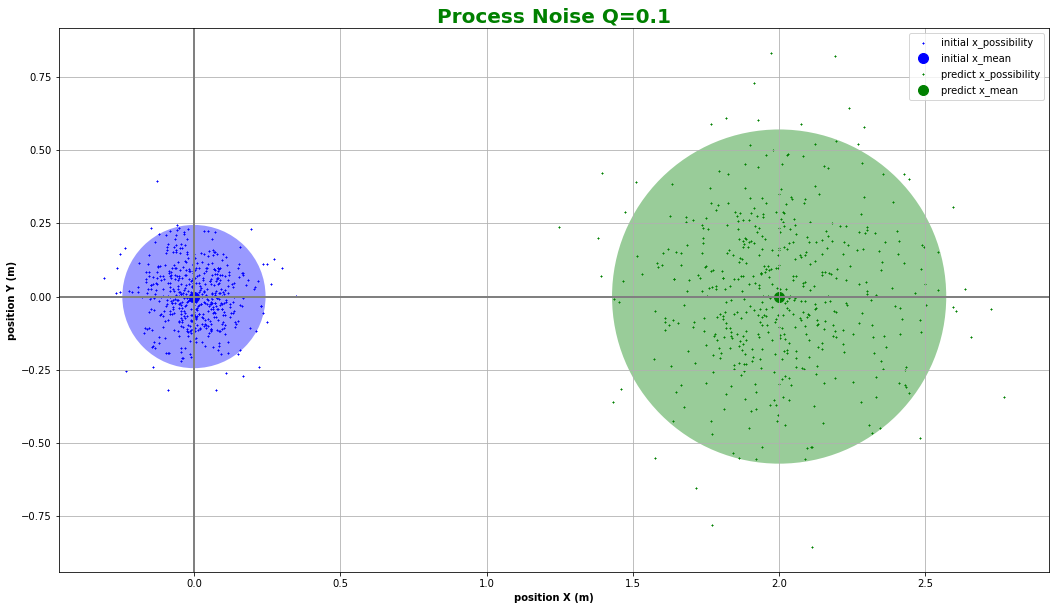

In [17]:
# propagating the previous state through the state transition matrix F_k

x0, P0, F, Q = prepare_prediction_example_1B()

x1, P1 = predict(x0, P0, F, Q)

viewer = create_viewer('Process Noise Q=0.1', 'position X (m)', 'position Y (m)')

visualize_estimate(viewer, 'initial', 'b', x0, P0)
visualize_estimate(viewer, 'predict', 'g', x1, P1)

update_plotter()

### Example 2

This example will be similar to Example 1.A but we will increase the initial uncertainty for the velocities while keeping process noise covariance zero $Q=0_{4 \times 4}$.

$$
P_0 = \begin{bmatrix} 0.1 & 0 & 0 & 0 \\ 0 & 0.1 & 0 & 0 \\ 0 & 0 & 0.1 & 0 \\ 0 & 0 & 0 & 0.1 \end{bmatrix}
$$

We find that the new predicted position has bigger uncertainty although we didn't add any process noise covariance. And this increase came from the correlation between the position and velocity as the uncertainty of the velocity is added up to the uncertainty of the position at the initial position resulting in more position uncertainty.

In [18]:
def prepare_prediction_example_2():
    # build initial state vector and covariance
    x = np.array([[0.], [0.], [2.], [0.]]) # x, y, vx, vy

    P = np.zeros((4, 4))
    P[0:2,0:2] = np.array([[0.1, 0.0], [0.0, 0.1]])
    P[2:4,2:4] = np.array([[0.1, 0.0], [0.0, 0.1]])

    F = np.array([[1., 0., T, 0.],
                  [0., 1., 0., T],
                  [0., 0., 1., 0.],
                  [0., 0., 0., 1.]])

    Q = np.zeros((4, 4))
    
    return x, P, F, Q

initial x [[0.]
 [0.]
 [2.]
 [0.]] 

initial P [[0.1 0.  0.  0. ]
 [0.  0.1 0.  0. ]
 [0.  0.  0.1 0. ]
 [0.  0.  0.  0.1]] 

predict x [[2.]
 [0.]
 [2.]
 [0.]] 

predict P [[0.2 0.  0.1 0. ]
 [0.  0.2 0.  0.1]
 [0.1 0.  0.1 0. ]
 [0.  0.1 0.  0.1]] 



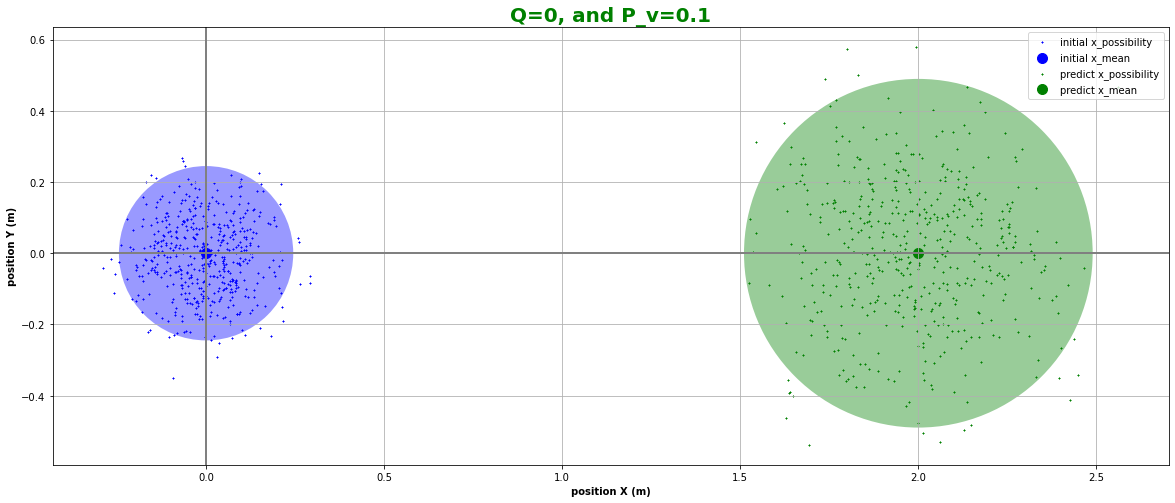

In [19]:
# Example (2)

x0, P0, F, Q = prepare_prediction_example_2()

x1, P1 = predict(x0, P0, F, Q)

viewer = create_viewer('Q=0, and P_v=0.1', 'position X (m)', 'position Y (m)')

visualize_estimate(viewer, 'initial', 'b', x0, P0)
visualize_estimate(viewer, 'predict', 'g', x1, P1)

update_plotter()

### Example 3

Now, we check what happen if we set the initial velocity in y-axis to an arbitrary value $v_y=1$ Such that:

$$
x_0 = \begin{bmatrix} p_X \\ p_y \\ v_x \\ v_y \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\ 2 \\ 1\end{bmatrix}
$$

We find that the new predicted position is moved along both x- and y-axis.

In [20]:
def prepare_prediction_example_3():
    # build initial state vector and covariance
    x = np.array([[0.], [0.], [2.], [1.]]) # x, y, vx, vy

    P = np.zeros((4, 4))
    P[0:2,0:2] = np.array([[0.1, 0.0], [0.0, 0.1]])
    P[2:4,2:4] = np.array([[0.1, 0.0], [0.0, 0.1]])

    F = np.array([[1., 0., T, 0.],
                  [0., 1., 0., T],
                  [0., 0., 1., 0.],
                  [0., 0., 0., 1.]])

    Q = np.zeros((4, 4))
    
    return x, P, F, Q

initial x [[0.]
 [0.]
 [2.]
 [1.]] 

initial P [[0.1 0.  0.  0. ]
 [0.  0.1 0.  0. ]
 [0.  0.  0.1 0. ]
 [0.  0.  0.  0.1]] 

predict x [[2.]
 [1.]
 [2.]
 [1.]] 

predict P [[0.2 0.  0.1 0. ]
 [0.  0.2 0.  0.1]
 [0.1 0.  0.1 0. ]
 [0.  0.1 0.  0.1]] 



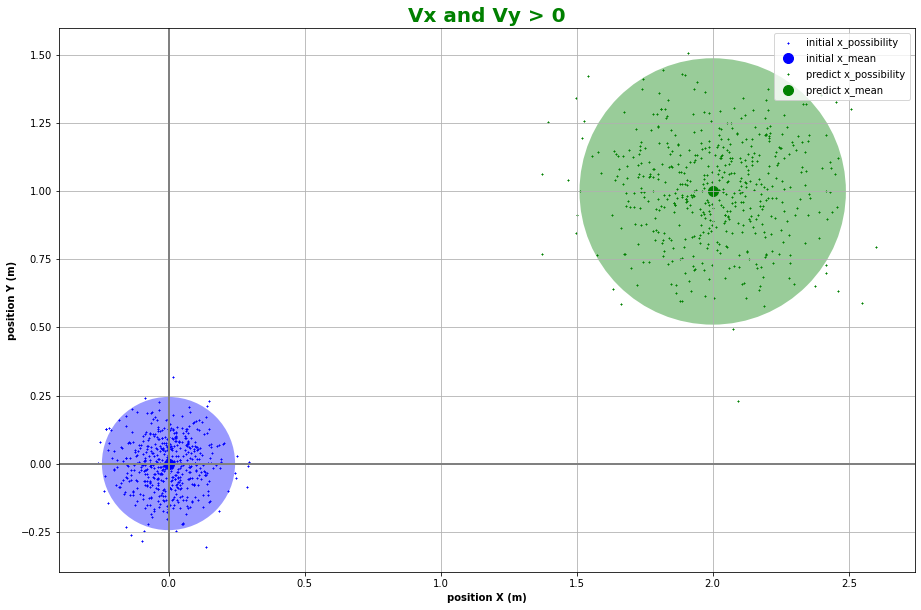

In [21]:
# Example (3)

x0, P0, F, Q = prepare_prediction_example_3()

x1, P1 = predict(x0, P0, F, Q)

viewer = create_viewer('Vx and Vy > 0', 'position X (m)', 'position Y (m)')

visualize_estimate(viewer, 'initial', 'b', x0, P0)
visualize_estimate(viewer, 'predict', 'g', x1, P1)

update_plotter()

### Covariance Visualization

Lets visualize the covariance in 2D and see how it changes in case there is a correlation and in case there is not.

This time we will make a 2D plot of $p_x$ (x-axis) and $v_x$ (y_axis) since the correlation are between these two elements in the state vector $x_k$.

 x [[0.]
 [0.]] 

 P [[0.1 0. ]
 [0.  0.1]] 



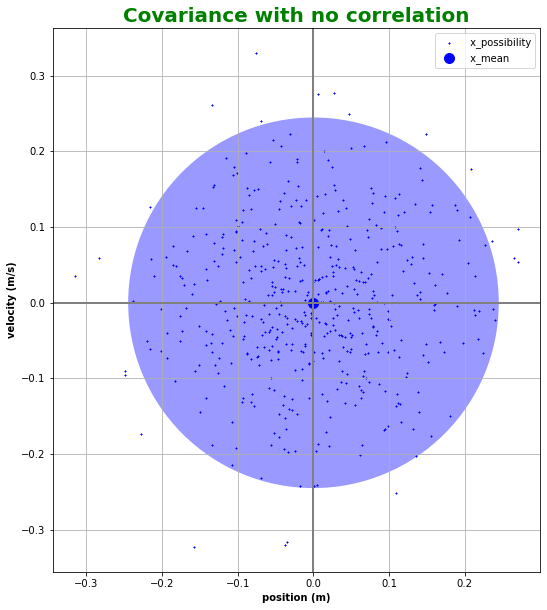

In [22]:
P = np.array([[0.1, 0.0], [0.0, 0.1]])

T = 1.0 # sampling time = 1 sec

P_0 = np.zeros((4, 4))
P_0[0:2,0:2] = np.array([[0.1, 0.0], [0.0, 0.1]])
P_0[2:4,2:4] = np.array([[0.1, 0.0], [0.0, 0.1]])

F = np.array([[1., 0., 0., 0.],
              [0., 1., 0., 0.],
              [0., 0., 1., 0.],
              [0., 0., 0., 1.]])

P_1 = F @ P_0 @ F.T

P = np.zeros((2, 2))
P[0, 0] = P_1[0, 0]
P[0, 1] = P_1[0, 2]
P[1, 0] = P_1[2, 0]
P[1, 1] = P_1[2, 2]

x = np.array([[0.], [0.]]) # x, y, vx, vy

viewer = create_viewer(title='Covariance with no correlation', xlabel='position (m)', ylabel='velocity (m/s)')

visualize_estimate(viewer, '', 'b', x, P)

update_plotter()

 x [[0.]
 [0.]] 

 P [[0.2 0.1]
 [0.1 0.1]] 



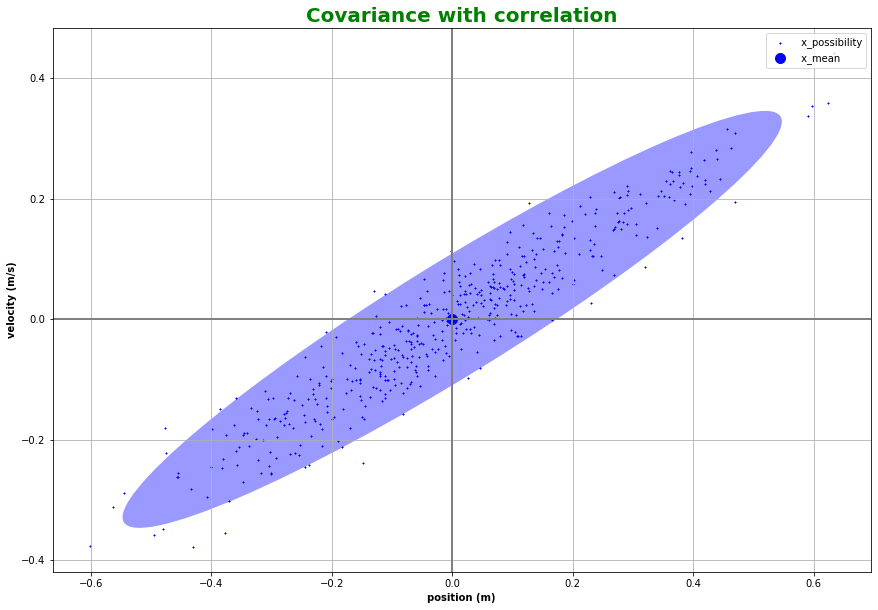

In [23]:
# propagating the previous state through the state transition matrix F_k
T = 1.0 # sampling time = 1 sec

P_0 = np.zeros((4, 4))
P_0[0:2,0:2] = np.array([[0.1, 0.0], [0.0, 0.1]])
P_0[2:4,2:4] = np.array([[0.1, 0.0], [0.0, 0.1]])

F = np.array([[1., 0., T, 0.],
              [0., 1., 0., T],
              [0., 0., 1., 0.],
              [0., 0., 0., 1.]])

P_1 = F @ P_0 @ F.T

P = np.zeros((2, 2))
P[0, 0] = P_1[0, 0]
P[0, 1] = P_1[0, 2]
P[1, 0] = P_1[2, 0]
P[1, 1] = P_1[2, 2]

x = np.array([[0.], [0.]]) # x, y, vx, vy

viewer = create_viewer(title='Covariance with correlation', xlabel='position (m)', ylabel='velocity (m/s)')

visualize_estimate(viewer, '', 'b', x, P)

update_plotter()

## Update Step (Example 1D)

We will assume that we know the initial position of the robot and also the velocity at that time.

$$
x_0 = \begin{bmatrix} p_x \\ v_x \end{bmatrix} = \begin{bmatrix} 0 \\ 2 \end{bmatrix}
$$

Since the velocity along x-axis isn't zero, so one can expect that the robot will move by 2 units along x-axis at the next cycle, given that the sample time is 1 second $T = 1 sec$.

We set the initial state covariance as follows:

$$
P_0 = \begin{bmatrix} 0.1 & 0 \\ 0 & 0.1 \end{bmatrix}
$$

Process noise:

$$
Q_k' =
\begin{bmatrix}
    q_{11}T+q_{33}\frac{T^3}{3} & q_{22} \frac{T^2}{2} \\
    q_{22} \frac{T^2}{2} & q_{22} T\\
\end{bmatrix}
$$

where;

$$
Q =
\begin{bmatrix}
    q_{11} & 0 \\
    0 & q_{22}
\end{bmatrix}
= 
\begin{bmatrix}
    0.1 & 0 \\
    0 & 0.1
\end{bmatrix}
$$

Prediction Model:

$$
F_k =
\begin{bmatrix}
    1 & T \\
    0 & 1
\end{bmatrix}
$$

Measurement:

$$
z =
\begin{bmatrix}
    2.25
\end{bmatrix}
$$


Measurement Noise:

$$
R =
\begin{bmatrix}
    0.01
\end{bmatrix}
$$

Measurement Model:

$$
H =
\begin{bmatrix}
    1 & 0
\end{bmatrix}
$$

Prediction step:

$$
x_{k|k-1} = F_k x_{k-1|k-1}
$$

$$
P_{k|k-1} = F_k P_{k-1|k-1} F_k^T + Q_k'
$$

Update step:

$$
\vec{z}_k - H_k \vec{x}_{k|k-1}
$$

$$
S_{k} = H_k P_{k|k-1} H_k^T + R_k
$$

$$
\vec{x}_{k|k} = \vec{x}_{k|k-1} + K_k (\vec{z}_k - H \vec{x}_{k|k-1})
$$

$$
P_{k|k} = (I - K_k H_k) P_{k|k-1}
$$

In [24]:
def correct(x, P, z, H, R):
    I = np.eye(len(P))
    S = H @ P @ H.T + R
    K = P @ H.T @ np.linalg.pinv(S)
    x = x + K @ (z - H @ x)
    P = (I - K @ H) @ P
    return x, P

In [25]:
def prepare_update_example_1D():
    x = np.array([[0.], [2.]])
    P = np.array([[0.1, 0.0], [0.0, 0.1]])

    F = np.array([[1., T],
                  [0., 1.]])

    q_11 = q_33 = 0.1

    Q = np.array([[q_11 * T + q_33 * (T**3/3), q_33 * (T**2/2)],
                  [q_33 * (T**2/2), q_33 * T]])
    
    # a position measurement received
    z = np.array([[2.25]])
    R = np.array([[0.01]])
    H = np.array([[1.0, 0.0]])
    
    return x, P, F, Q, z, R, H

 x [[2.]
 [2.]] 

 P [[0.33333333 0.15      ]
 [0.15       0.2       ]] 



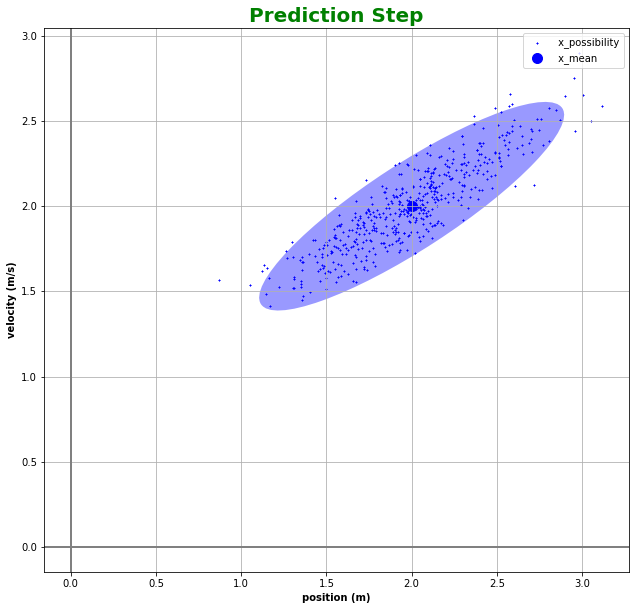

In [26]:
x, P, F, Q, z, R, H = prepare_update_example_1D()

x, P = predict(x, P, F, Q)

viewer = create_viewer(title='Prediction Step', xlabel='position (m)', ylabel='velocity (m/s)')

visualize_estimate(viewer, '', 'b', x, P)

update_plotter()

 x [[2.]
 [2.]] 

 P [[0.33333333 0.15      ]
 [0.15       0.2       ]] 



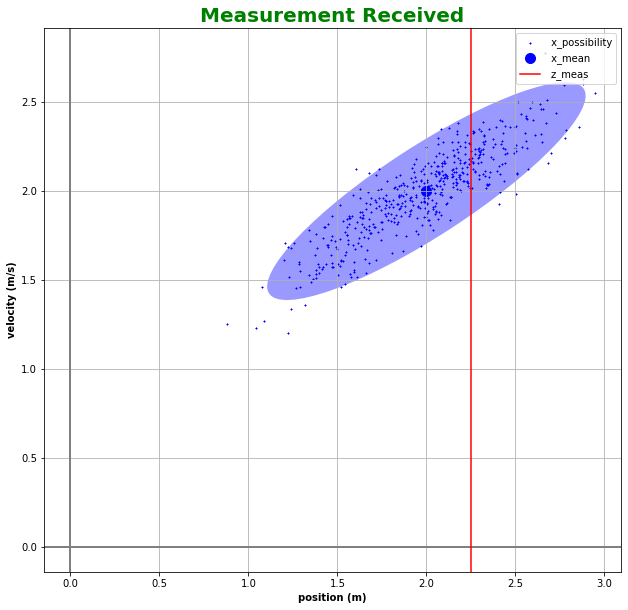

In [27]:
# a position measurement received

viewer = create_viewer(title='Measurement Received', xlabel='position (m)', ylabel='velocity (m/s)')

visualize_estimate(viewer, '', 'b', x, P)
viewer.axvline(z[0], c='red', label=' z_meas') # measurement z

update_plotter()

predicted x [[2.]
 [2.]] 

predicted P [[0.33333333 0.15      ]
 [0.15       0.2       ]] 

corrected x [[2.24271845]
 [2.1092233 ]] 

corrected P [[0.00970874 0.00436893]
 [0.00436893 0.13446602]] 



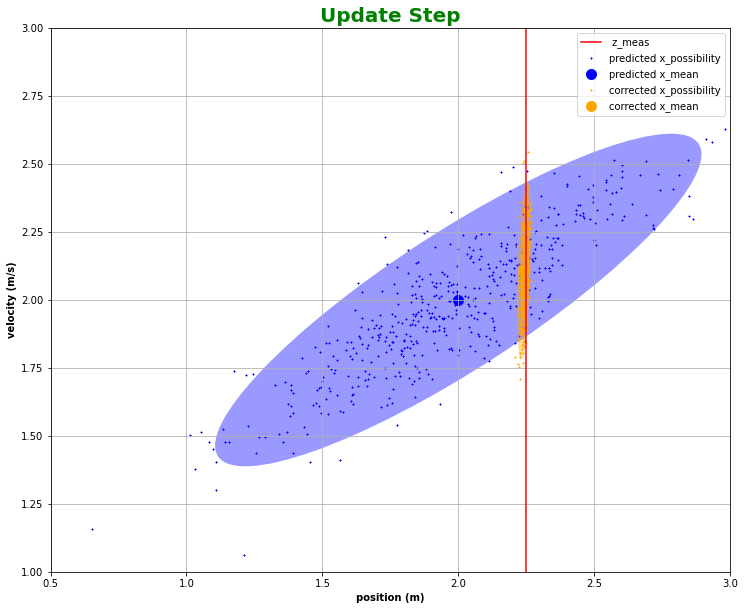

In [30]:
x1, P1 = correct(x, P, z, H, R)

viewer = create_viewer(title='Update Step', xlabel='position (m)', ylabel='velocity (m/s)', xlim=(0.5, 3), ylim=(1, 3))

viewer.axvline(z[0], c='red', label=' z_meas') # measurement z

visualize_estimate(viewer, 'predicted', 'blue', x, P)
visualize_estimate(viewer, 'corrected', 'orange', x1, P1)

update_plotter()